# Goal
- implement epsilon greedy algorithms for suggesting top 5 movie for each user 
- reward is the overlap between suggested movie and the 5 most like movie in the focal group
- arm is movies with greater than 200 ratings
- div the dataset with 
‣ Male, Young (age < 30)
‣ Male, Adult (age ≥ 30)
‣ Female, Young (age < 30)
‣ Female, Adult (age ≥ 30) 

## Potential questions
- reward choice: binary or use the actual rating 


# load data

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [30]:
user_info = pd.read_table('u.user', header=None,names=['user_id', 'age','gender','occupation','zip_code'],sep='|')
user_rating = pd.read_table('u.data', header=None,names=['user_id','item_id','rating','timestamp'])

In [31]:
user_rating_with_info = pd.merge(user_rating, user_info, left_on='user_id', right_on='user_id')
user_rating_with_info.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


## get movies with more than 200 ratings

In [32]:
movie_rating_count = user_rating.groupby('item_id')['rating'].count()
movie_with_gt_200_rating = movie_rating_count[movie_rating_count > 200]
movie_with_gt_200_rating.index


Int64Index([  1,   4,   7,   8,   9,  11,  12,  15,  22,  25,
            ...
            515, 546, 568, 588, 597, 603, 655, 678, 742, 748],
           dtype='int64', name='item_id', length=117)

### filter full dataset with this movie list


In [33]:

user_rating_with_info = user_rating_with_info[user_rating_with_info['item_id'].isin(movie_with_gt_200_rating)]


## split user data

In [34]:
male_young = user_rating_with_info[(user_rating_with_info['age'] < 30) & (user_rating_with_info['gender'] == 'M')]
male_adult = user_rating_with_info[(user_rating_with_info['age'] >= 30) & (user_rating_with_info['gender'] == 'M')]
female_young = user_rating_with_info[(user_rating_with_info['age'] < 30) & (user_rating_with_info['gender'] == 'F')]
female_adult = user_rating_with_info[(user_rating_with_info['age'] >- 30) & (user_rating_with_info['gender'] == 'F')]

## get top 5 most like movie for each focal group

In [41]:
#get mean for movie in each focal group and get highest 5

male_young_top5_movie = male_young.groupby('item_id')['rating'].mean().nlargest(5).index
male_adult_top5_movie = male_adult.groupby('item_id')['rating'].mean().nlargest(5).index
female_young_top5_movie = female_young.groupby('item_id')['rating'].mean().nlargest(5).index
female_adult_top5_movie = female_adult.groupby('item_id')['rating'].mean().nlargest(5).index

In [42]:
female_adult_top5_movie

Int64Index([251, 223, 272, 478, 275], dtype='int64', name='item_id')

# construct MAB

In [49]:
from tqdm import tqdm

class ReplaySimulator():
    def __init__(self, n_visits, reward_history, item_col_name, top5_like_movie, n_iterations=1, random_seed=1):
        # Set the random seed for reproducibility
        np.random.seed(random_seed)
        
        self.top5_like_movie = top5_like_movie
        # Store input data and parameters
        self.reward_history = reward_history
        self.item_col_name = item_col_name

        # Number of visits to replay/simulate
        # ammendment: use the whole dataset to simulate as the average number of rows are 2500
        self.n_visits = n_visits

        # Number of runs to average over
        self.n_iterations = n_iterations

        # Items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)

    def reset(self):
        # Initialize counters for item samples and rewards
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def simulate(self):
        # Store simulation results
        results = []

        for iteration in range(0, self.n_iterations):
            # Reset counters for each iteration
            self.reset()

            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in tqdm(range(0, self.n_visits)):
                
                # Select 5 items to offer the visitor
                item_idx = self.select_item()
                item_id_list = self.items[item_idx]
                
                # percentage overlap between 5 drawed arms and 5 top like arm 
                reward_value = float(len(set(item_id_list) & set(self.top5_like_movie))) / 5 *100

                self.record_result(visit, item_idx, reward_value)

                # Record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)

                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['recommendation'] = item_id_list
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)

                results.append(result)

        return results

    def select_item(self):
        # This method selects 5 item randomly
        return [np.random.randint(self.n_items) for i in range(5)]
        # return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        # This method records the result of an interaction and updates item statistics

        # Update the number of times the item has been sampled
        self.n_item_samples[item_idx] += 1

        # Update the fraction of time the item has resulted in a reward
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])


class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, top5_like_movie ,n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, top5_like_movie, n_iterations)
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
            
        else: # exploit
            #item_id = np.argmax(self.n_item_rewards)
            item_id = self.n_item_rewards.argsort()[-5:][::-1]
            
        return item_id

In [99]:
#maximum number of row in csv is 6w
n_visits = 5000
n_iterations = 10

reward_history_list = [male_young,male_adult,female_young,female_adult]
reward_reference_list = [male_young_top5_movie,male_adult_top5_movie,female_young_top5_movie,female_adult_top5_movie]
reward_history_list_name = ['male_young','male_adult','female_young','female_adult']
item_col_name = 'item_id'


In [100]:
epsilon_values = [0.05,0.1,0.3,0.5,0.7]
for i in range(len(reward_history_list)):
    reward_history = reward_history_list[i]
    for epsilon in epsilon_values:
        print(reward_history_list_name[i],epsilon)
        results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history, item_col_name, reward_reference_list[i] ,n_iterations).simulate()
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'output/{reward_history_list_name[i]}_e={epsilon}.csv')


male_young 0.05


100%|██████████| 5000/5000 [00:00<00:00, 27831.96it/s]


male_young 0.1


100%|██████████| 5000/5000 [00:00<00:00, 25779.40it/s]


male_young 0.3


100%|██████████| 5000/5000 [00:00<00:00, 21116.23it/s]


male_young 0.5


100%|██████████| 5000/5000 [00:00<00:00, 17935.21it/s]


male_young 0.7


100%|██████████| 5000/5000 [00:00<00:00, 15107.65it/s]


male_adult 0.05


100%|██████████| 5000/5000 [00:00<00:00, 28883.37it/s]


male_adult 0.1


100%|██████████| 5000/5000 [00:00<00:00, 17694.05it/s]


male_adult 0.3


100%|██████████| 5000/5000 [00:00<00:00, 18937.26it/s]


male_adult 0.5


100%|██████████| 5000/5000 [00:00<00:00, 15768.44it/s]


male_adult 0.7


100%|██████████| 5000/5000 [00:00<00:00, 15165.83it/s]


female_young 0.05


100%|██████████| 5000/5000 [00:00<00:00, 29098.66it/s]


female_young 0.1


100%|██████████| 5000/5000 [00:00<00:00, 20051.29it/s]


female_young 0.3


100%|██████████| 5000/5000 [00:00<00:00, 14963.06it/s]


female_young 0.5


100%|██████████| 5000/5000 [00:00<00:00, 18202.71it/s]


female_young 0.7


100%|██████████| 5000/5000 [00:00<00:00, 14801.77it/s]


female_adult 0.05


100%|██████████| 5000/5000 [00:00<00:00, 28620.25it/s]


female_adult 0.1


100%|██████████| 5000/5000 [00:00<00:00, 22815.57it/s]


female_adult 0.3


100%|██████████| 5000/5000 [00:00<00:00, 19846.09it/s]


female_adult 0.5


100%|██████████| 5000/5000 [00:00<00:00, 17677.08it/s]


female_adult 0.7


100%|██████████| 5000/5000 [00:00<00:00, 14951.61it/s]


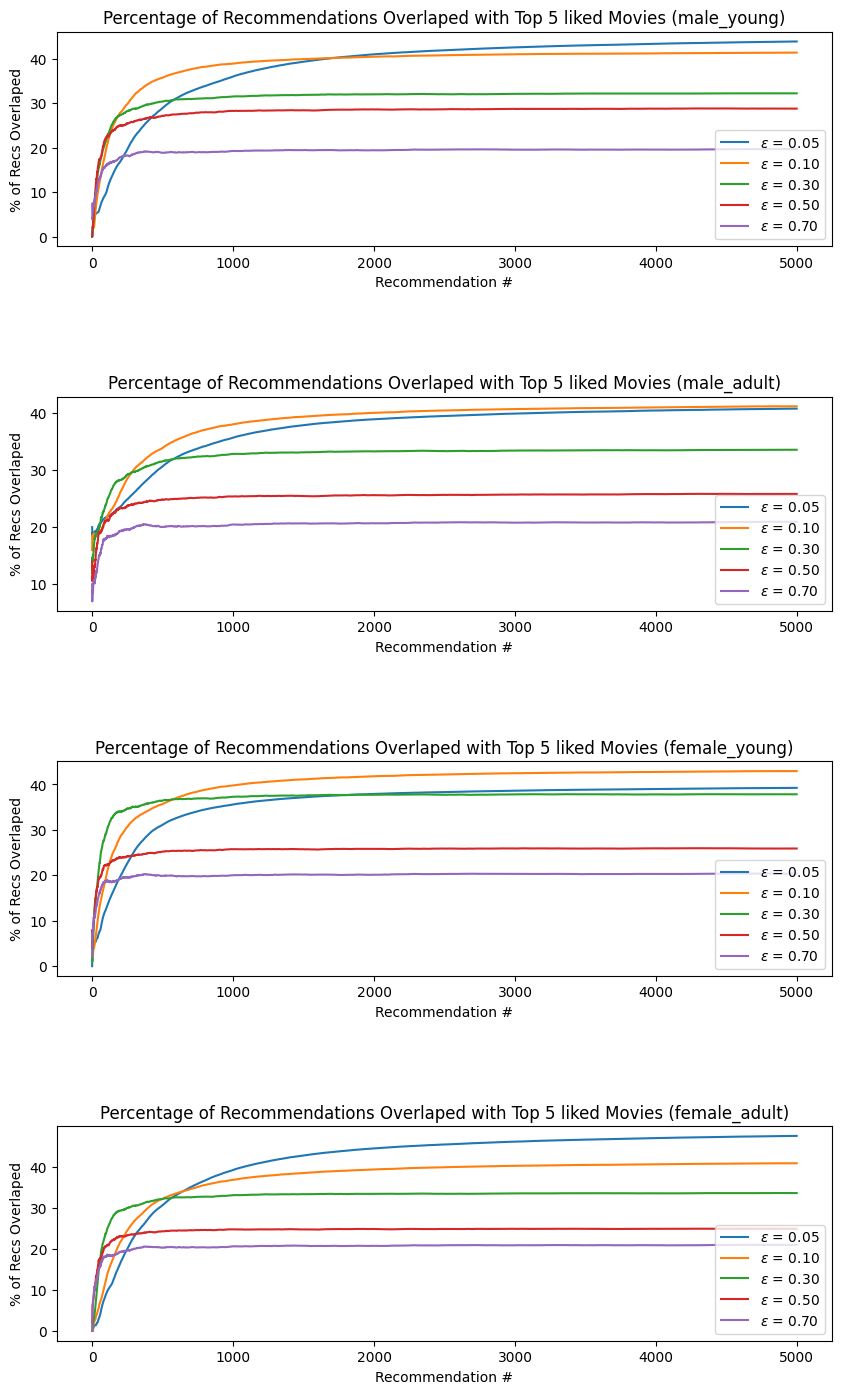

In [101]:
fig, ax = plt.subplots(4,1, figsize=(10,17),squeeze=False)
for i in range(len(reward_history_list)):
    result_df_list = []
    result_avg_df_list = []
    focal_group = reward_history_list_name[i]
    for epsilon in epsilon_values:
        df = pd.read_csv(f'output/{focal_group}_e={epsilon}.csv', index_col=0)
        result_df_list.append(df)
        result_avg_df_list.append(df.groupby('visit',as_index=False).mean())
        
    

    for avg_results_df in result_avg_df_list:
        ax[i,0].plot(avg_results_df.visit, avg_results_df['fraction_relevant'], linewidth=1.5)

    ax[i,0].set_title(f'Percentage of Recommendations Overlaped with Top 5 liked Movies ({focal_group})')
    ax[i,0].set_xlabel('Recommendation #')
    ax[i,0].set_ylabel('% of Recs Overlaped')

    ax[i,0].legend([
            '$\epsilon$ = 0.05',
            '$\epsilon$ = 0.10',
            '$\epsilon$ = 0.30',
            '$\epsilon$ = 0.50',
            '$\epsilon$ = 0.70'
            ],
            loc='lower right'
            )
plt.subplots_adjust(hspace=0.7)
plt.show()

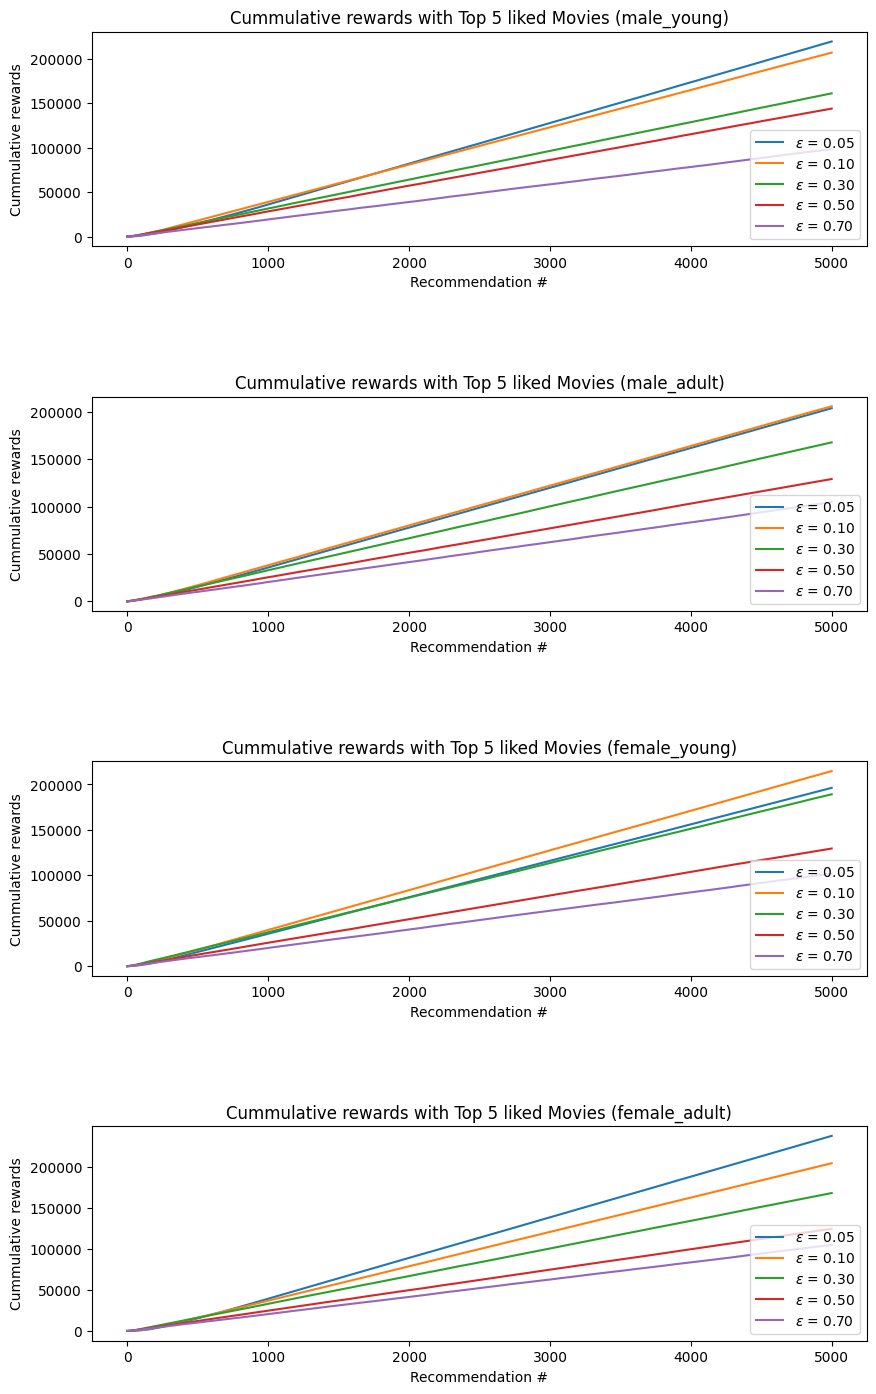

In [104]:
fig, ax = plt.subplots(4,1, figsize=(10,17),squeeze=False)
for i in range(len(reward_history_list)):
    result_df_list = []
    result_avg_df_list = []
    focal_group = reward_history_list_name[i]
    for epsilon in epsilon_values:
        df = pd.read_csv(f'output/{focal_group}_e={epsilon}.csv', index_col=0)
        result_df_list.append(df)
        result_avg_df_list.append(df.groupby('visit',as_index=False).mean())
        
    

    for avg_results_df in result_avg_df_list:
        ax[i,0].plot(avg_results_df.visit, avg_results_df['total_reward'], linewidth=1.5)

    ax[i,0].set_title(f'Cummulative rewards with Top 5 liked Movies ({focal_group})')
    ax[i,0].set_xlabel('Recommendation #')
    ax[i,0].set_ylabel('Cummulative rewards')

    ax[i,0].legend([
            '$\epsilon$ = 0.05',
            '$\epsilon$ = 0.10',
            '$\epsilon$ = 0.30',
            '$\epsilon$ = 0.50',
            '$\epsilon$ = 0.70'
            ],
            loc='lower right'
            )
plt.subplots_adjust(hspace=0.7)
plt.show()